# Imports

In [1]:
%load_ext autoreload
%autoreload 2


import os
from typing import List
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import sys
import logging 

logging.basicConfig(
     level=logging.INFO, 
     format= '[%(asctime)s|%(levelname)s|%(module)s.py:%(lineno)s] %(message)s',
     datefmt='%H:%M:%S'
 )
import tqdm.notebook as tq
from tqdm import tqdm
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

import torch
from torch import nn
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, 
    TrainingArguments, Trainer, EarlyStoppingCallback, IntervalStrategy, get_linear_schedule_with_warmup
)

from defi_textmine_2025.data.utils import TARGET_COL, INTERIM_DIR, MODELS_DIR, get_cat_var_distribution, compute_class_weights

[04:08:20|INFO|config.py:58] PyTorch version 2.3.1 available.
[04:08:20|INFO|config.py:105] TensorFlow version 2.16.2 available.
2024-10-11 04:08:20.838658: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-11 04:08:20.846740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 04:08:20.858128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 04:08:20.858150: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register fact

# Constants

In [2]:
BASE_CHECKPOINT = "camembert/camembert-large"


RANDOM_SEED = 0  # random reproducibility
np.random.seed(RANDOM_SEED)
logging.info(f"{RANDOM_SEED=}")
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


TASK_NAME = "hasrelation"
logging.info(f"{TASK_NAME=}")
STEP1_TASK_TARGET_COL = f"{TASK_NAME}_label"
logging.info(f"{STEP1_TASK_TARGET_COL=}")
TASK_INPUT_COL = "input_text"

FOLD_NUM = 1
logging.info(f"{FOLD_NUM=}")


entity_classes = {'TERRORIST_OR_CRIMINAL', 'LASTNAME', 'LENGTH', 'NATURAL_CAUSES_DEATH', 'COLOR', 'STRIKE', 'DRUG_OPERATION', 'HEIGHT', 'INTERGOVERNMENTAL_ORGANISATION', 'TRAFFICKING', 'NON_MILITARY_GOVERNMENT_ORGANISATION', 'TIME_MIN', 'DEMONSTRATION', 'TIME_EXACT', 'FIRE', 'QUANTITY_MIN', 'MATERIEL', 'GATHERING', 'PLACE', 'CRIMINAL_ARREST', 'CBRN_EVENT', 'ECONOMICAL_CRISIS', 'ACCIDENT', 'LONGITUDE', 'BOMBING', 'MATERIAL_REFERENCE', 'WIDTH', 'FIRSTNAME', 'MILITARY_ORGANISATION', 'CIVILIAN', 'QUANTITY_MAX', 'CATEGORY', 'POLITICAL_VIOLENCE', 'EPIDEMIC', 'TIME_MAX', 'TIME_FUZZY', 'NATURAL_EVENT', 'SUICIDE', 'CIVIL_WAR_OUTBREAK', 'POLLUTION', 'ILLEGAL_CIVIL_DEMONSTRATION', 'NATIONALITY', 'GROUP_OF_INDIVIDUALS', 'QUANTITY_FUZZY', 'RIOT', 'WEIGHT', 'THEFT', 'MILITARY', 'NON_GOVERNMENTAL_ORGANISATION', 'LATITUDE', 'COUP_D_ETAT', 'ELECTION', 'HOOLIGANISM_TROUBLEMAKING', 'QUANTITY_EXACT', 'AGITATING_TROUBLE_MAKING'}

USED_COLUMNS = ["text_index", "e1_id", "e2_id", "e1_type", "e2_type", TARGET_COL, TASK_INPUT_COL, STEP1_TASK_TARGET_COL]
logging.info(f"{USED_COLUMNS=}")

model_checkpoints_dir = os.path.join(MODELS_DIR, f"mth2-{TASK_NAME}-fold{FOLD_NUM}-{BASE_CHECKPOINT.split('/')[-1]}")
logging.info(f"{model_checkpoints_dir=}")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

[04:08:22|INFO|188901005.py:6] RANDOM_SEED=0
[04:08:22|INFO|188901005.py:12] TASK_NAME='hasrelation'
[04:08:22|INFO|188901005.py:14] STEP1_TASK_TARGET_COL='hasrelation_label'
[04:08:22|INFO|188901005.py:18] FOLD_NUM=1
[04:08:22|INFO|188901005.py:24] USED_COLUMNS=['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'relations', 'input_text', 'hasrelation_label']
[04:08:22|INFO|188901005.py:27] model_checkpoints_dir='data/defi-text-mine-2025/models/mth2-hasrelation-fold1-camembert-large'


device(type='cuda')

# Load data

In [3]:
def load_preprossed_data(parquet_path: str) -> pd.DataFrame:
    return pd.read_parquet(parquet_path, columns=USED_COLUMNS)

In [4]:
train_df = load_preprossed_data(f"data/defi-text-mine-2025/interim/train-fold{FOLD_NUM}-mth2.parquet")
train_df.head(2)

,text_index,e1_id,e2_id,e1_type,e2_type,relations,input_text,hasrelation_label
0,2576,1,0,FIRE,GATHERING,None,"Au milieu de l’[ interview ], un { incendie } ...",0
1,2576,0,1,GATHERING,FIRE,['HAS_CONSEQUENCE'],"Au milieu de l’{ interview }, un [ incendie ] ...",1


In [5]:
val_df = load_preprossed_data(f"data/defi-text-mine-2025/interim/validation-fold{FOLD_NUM}-mth2.parquet")
val_df.head(2)

,text_index,e1_id,e2_id,e1_type,e2_type,relations,input_text,hasrelation_label
3,2576,0,2,GATHERING,CBRN_EVENT,['HAS_CONSEQUENCE'],"Au milieu de l’{ interview }, un incendie est ...",1
6,2576,3,0,CIVILIAN,GATHERING,None,"Le matin du 10 janvier 2010, { Arthur } et Jac...",0


In [6]:
get_cat_var_distribution(train_df[STEP1_TASK_TARGET_COL])

,count,proportion
hasrelation_label,,
0,76424,0.782752
1,21211,0.217248


In [7]:
get_cat_var_distribution(val_df[STEP1_TASK_TARGET_COL])

,count,proportion
hasrelation_label,,
0,19226,0.78766
1,5183,0.21234


# Create the tokenized datasets for model input

## init the tokenizer

In [8]:
# Hyperparameters
tokenizer = AutoTokenizer.from_pretrained(BASE_CHECKPOINT)
tokenizer

CamembertTokenizerFast(name_or_path='camembert/camembert-large', vocab_size=32005, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>', 'additional_special_tokens': ['<s>NOTUSED', '</s>NOTUSED', '<unk>NOTUSED']}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>NOTUSED", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>NOTUSED", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<unk>NOTUSED", rstrip=False, lstrip=False, single_word=False, normalized=False, special=

## init the train-valid datasets from dataframe

In [9]:
def tokenize_function(example: dict):
    return tokenizer(example[TASK_INPUT_COL], truncation=True, max_length=300) # max n_token without loosing entity, see setp0_data_preparation
tokenized_datasets = DatasetDict({
    "train": Dataset.from_pandas(train_df, preserve_index=False).shuffle(seed=RANDOM_SEED),
    "validation": Dataset.from_pandas(val_df, preserve_index=False)
}).map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/97635 [00:00<?, ? examples/s]

Map:   0%|          | 0/24409 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'relations', 'input_text', 'hasrelation_label', 'input_ids', 'attention_mask'],
        num_rows: 97635
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'relations', 'input_text', 'hasrelation_label', 'input_ids', 'attention_mask'],
        num_rows: 24409
    })
})

In [10]:
tokenized_datasets["validation"][:2]

{'text_index': [2576, 2576],
 'e1_id': [0, 3],
 'e2_id': [2, 0],
 'e1_type': ['GATHERING', 'CIVILIAN'],
 'e2_type': ['CBRN_EVENT', 'GATHERING'],
 'relations': ["['HAS_CONSEQUENCE']", None],
 'input_text': ['Au milieu de l’{ interview }, un incendie est survenu dans le bâtiment causé par une [ fuite ] de pétrole brut mal conditionné.',
  'Le matin du 10 janvier 2010, { Arthur } et Jacques Laurent, cofondateurs de l’association « Jeunes marins », ont donné une [ conférence de presse ] dans leurs locaux.'],
 'hasrelation_label': [1, 0],
 'input_ids': [[5,
   245,
   907,
   7,
   15,
   9,
   3,
   5715,
   20,
   3,
   8,
   25,
   6841,
   30,
   15048,
   28,
   16,
   1864,
   13589,
   36,
   29,
   402,
   5609,
   7774,
   7,
   4730,
   6230,
   430,
   18984,
   10,
   6],
  [5,
   43,
   1010,
   24,
   180,
   354,
   4376,
   20,
   3,
   10066,
   20,
   3,
   13,
   1576,
   2198,
   8,
   28717,
   11,
   7,
   15,
   9,
   926,
   47,
   7892,
   8954,
   214,
   88,
   90

# Init the data collator

In [11]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Fine-tuning a model with the Trainer API

## Compute the weight of classes to handle imbalance

In [12]:
get_cat_var_distribution(train_df[STEP1_TASK_TARGET_COL])["count"]

hasrelation_label
0    76424
1    21211
Name: count, dtype: int64

In [13]:
get_cat_var_distribution(train_df[STEP1_TASK_TARGET_COL]).reset_index(drop=False)["count"]

0    76424
1    21211
Name: count, dtype: int64

In [14]:
# Source: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
n_examples = train_df.shape[0]
n_classes = train_df[STEP1_TASK_TARGET_COL].nunique()
# def compute_class_weights2(lbl_df: pd.DataFrame) -> pd.Series:
#     return get_cat_var_distribution(lbl_df[STEP1_TASK_TARGET_COL]).reset_index(drop=False)["count"].apply(lambda x: (1 / x) * (n_examples / n_classes)).rename("weight")
# class_weights_df = compute_class_weights2(train_df)
class_weights_df = compute_class_weights(train_df, label_columns=[STEP1_TASK_TARGET_COL])
pd.concat([get_cat_var_distribution(train_df[STEP1_TASK_TARGET_COL]), class_weights_df], axis=1)

,count,proportion,weight
hasrelation_label,,,
0,76424,0.782752,0.638772
1,21211,0.217248,2.301518


In [15]:
class_weights = class_weights_df.values.tolist()
class_weights

[0.6387718517743117, 2.3015180802413844]

### Init the model

In [16]:
n_classes = train_df[STEP1_TASK_TARGET_COL].nunique()
print(f"{n_classes=}")
model = AutoModelForSequenceClassification.from_pretrained(BASE_CHECKPOINT, num_labels=n_classes)
model.resize_token_embeddings(len(tokenizer))

n_classes=2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert/camembert-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(32005, 1024, padding_idx=1)

In [17]:
model

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-23): 24 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=1024, out_feature

### Init the trainer and launch the training

Source: https://stackoverflow.com/questions/69087044/early-stopping-in-bert-trainer-instances#69087153

1. Use `load_best_model_at_end = True` (EarlyStoppingCallback() requires this to be True).
2. `evaluation_strategy = 'steps'` or IntervalStrategy.STEPS instead of 'epoch'.
3. `eval_steps = 50` (evaluate the metrics after N steps).
4. `metric_for_best_model = 'f1'`

In [46]:
def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average="macro")
    precision = precision_score(y_true=labels, y_pred=pred, average="macro")
    f1 = f1_score(y_true=labels, y_pred=pred, average="macro")    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

MAX_EPOCHS = 50
TRAIN_BATCH_SIZE=8
VAL_BATCH_SIZE=8
LEARNING_RATE = 1e-6
WEIGHT_DECAY = 0.01

training_args = TrainingArguments(
    output_dir=model_checkpoints_dir,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,    
    per_device_eval_batch_size=VAL_BATCH_SIZE,
    num_train_epochs=MAX_EPOCHS,
    eval_strategy=IntervalStrategy.STEPS, # steps
    eval_steps = 3000, # Evaluation and Save happens every 50 steps
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    save_strategy=IntervalStrategy.STEPS,
    save_steps=3000,
    save_total_limit=1, # Only last 2 models are saved. Older ones are deleted
    push_to_hub=False,
    # label_names=[STEP1_TASK_TARGET_COL],
    metric_for_best_model='f1',
    greater_is_better=True,
    load_best_model_at_end=True,
    report_to="none",
)

class CustomTrainer(Trainer):    
    def compute_loss(self, model, inputs, return_outputs=False):
        """customize the loss to leverage class weights"""
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


# optimizer = torch.optim.RAdam(
#         model.parameters(),
#         lr=LEARNING_RATE,
#         betas=(0.9, 0.999),
#         eps=1e-8,
#         weight_decay=WEIGHT_DECAY,
#     )
# total_steps = int(tokenized_datasets["train"].num_rows/TRAIN_BATCH_SIZE) * training_args.num_train_epochs
# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=int(0.1 * total_steps),
#     num_training_steps=total_steps
# )

trainer = CustomTrainer(
    model,
    args=training_args,
    # optimizers=(optimizer, scheduler),
    train_dataset=tokenized_datasets["train"].rename_column(STEP1_TASK_TARGET_COL, "label"),
    eval_dataset=tokenized_datasets["validation"].rename_column(STEP1_TASK_TARGET_COL, "label"),
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=4)],
)

# trainer.train()

## Launch training

In [19]:
BASE_CHECKPOINT

'camembert/camembert-large'

In [20]:
# trainer.train(resume_from_checkpoint=trainer.state.best_model_checkpoint)
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
3000,0.486000,0.486070,0.800975,0.728041,0.798759,0.746551
6000,0.462600,0.456625,0.848007,0.773082,0.817411,0.790642
9000,0.438500,0.464117,0.847433,0.774933,0.837340,0.796772
12000,0.456500,0.580480,0.882379,0.847400,0.779196,0.805930
15000,0.425600,0.422613,0.856242,0.786155,0.854135,0.809569
18000,0.457500,0.411015,0.883281,0.820574,0.847553,0.832736
21000,0.436100,0.400828,0.865705,0.797018,0.862890,0.820621
24000,0.378000,0.419048,0.874473,0.807385,0.869865,0.830704
27000,0.377700,0.474917,0.897333,0.843068,0.856614,0.849539
30000,0.389900,0.484759,0.900201,0.852088,0.847795,0.849912


TrainOutput(global_step=96000, training_loss=0.37916453035672504, metrics={'train_runtime': 31755.2552, 'train_samples_per_second': 153.73, 'train_steps_per_second': 19.217, 'total_flos': 1.6087409461989213e+17, 'train_loss': 0.37916453035672504, 'epoch': 7.865628840639082})

# Evaluate

In [ ]:
# trainer.train(resume_from_checkpoint=True)

In [48]:
trainer.state.best_metric

0.8773845381229319

In [49]:
# After training, access the path of the best checkpoint like this
best_ckpt_path = trainer.state.best_model_checkpoint
best_ckpt_path

'data/defi-text-mine-2025/models/mth2-hasrelation-fold1-camembert-large/checkpoint-84000'

In [40]:
trainer.state.best_model_checkpoint

In [44]:
trainer._load_best_model()

## Get the labels

In [24]:
train_pred_output = trainer.predict(tokenized_datasets["train"], metric_key_prefix="train")

In [31]:
train_y_pred = torch.sigmoid(torch.from_numpy(train_pred_output.predictions)).argmax(axis=1).numpy()
train_y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [60]:
# train_y_true = val_pred_output.label_ids
train_y_true = tokenized_datasets['train'][STEP1_TASK_TARGET_COL]
print(train_y_true)

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
val_pred_output = trainer.predict(tokenized_datasets["validation"], metric_key_prefix="validation")

In [51]:
val_y_pred = torch.sigmoid(torch.from_numpy(val_pred_output.predictions)).argmax(axis=1).numpy()
val_y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [59]:
# val_y_true = val_pred_output.label_ids
val_y_true = tokenized_datasets['validation'][STEP1_TASK_TARGET_COL]
print(val_y_true)

[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Global metrics

In [52]:
train_pred_output.metrics

{'train_runtime': 806.2969,
 'train_samples_per_second': 121.091,
 'train_steps_per_second': 15.137}

In [53]:
val_pred_output.metrics

{'validation_runtime': 192.9515,
 'validation_samples_per_second': 126.503,
 'validation_steps_per_second': 15.817}

## Classification report

In [61]:
print(classification_report(y_true=train_y_true, y_pred=train_y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     76424
           1       0.86      0.95      0.90     21211

    accuracy                           0.95     97635
   macro avg       0.92      0.95      0.94     97635
weighted avg       0.96      0.95      0.96     97635



In [62]:
print(classification_report(y_true=val_y_true, y_pred=val_y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     19226
           1       0.76      0.87      0.81      5183

    accuracy                           0.91     24409
   macro avg       0.86      0.90      0.88     24409
weighted avg       0.92      0.91      0.92     24409



## Confusion matrix

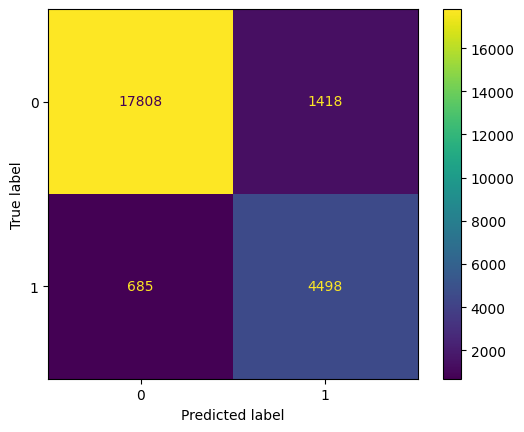

In [65]:
cm = confusion_matrix(y_true=val_y_true, y_pred=val_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

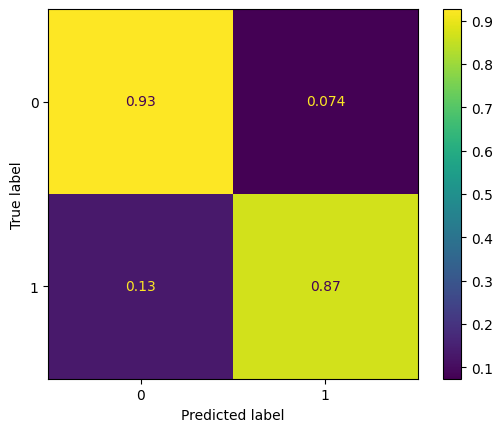

In [66]:
cm = confusion_matrix(y_true=val_y_true, y_pred=val_y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Error analysis

TODO...

In [77]:
tokenized_datasets["validation"].select_columns(USED_COLUMNS).to_pandas()

,text_index,e1_id,e2_id,e1_type,e2_type,relations,input_text,hasrelation_label
0,2576,0,2,GATHERING,CBRN_EVENT,['HAS_CONSEQUENCE'],"Au milieu de l’{ interview }, un incendie est ...",1
1,2576,3,0,CIVILIAN,GATHERING,None,"Le matin du 10 janvier 2010, { Arthur } et Jac...",0
2,2576,4,2,CIVILIAN,CBRN_EVENT,None,"Le matin du 10 janvier 2010, Arthur et { Jacqu...",0
3,2576,3,4,CIVILIAN,CIVILIAN,['HAS_FAMILY_RELATIONSHIP'],"Le matin du 10 janvier 2010, { Arthur } et [ J...",1
4,2576,5,1,GROUP_OF_INDIVIDUALS,FIRE,None,"Le matin du 10 janvier 2010, Arthur et Jacques...",0
...,...,...,...,...,...,...,...,...
24404,41884,0,20,THEFT,TIME_EXACT,"['START_DATE', 'END_DATE']","Le [ 14 janvier 2014 ], en pleine Sibérie, dan...",1
24405,41884,7,20,NON_MILITARY_GOVERNMENT_ORGANISATION,TIME_EXACT,None,"Le [ 14 janvier 2014 ], en pleine Sibérie, dan...",0
24406,41884,15,20,MATERIEL,TIME_EXACT,None,"Le [ 14 janvier 2014 ], en pleine Sibérie, dan...",0
24407,41884,17,20,MATERIEL,TIME_EXACT,None,"Le [ 14 janvier 2014 ], en pleine Sibérie, dan...",0


In [80]:
val_y_true_vs_pred_df = pd.concat([pd.DataFrame({"y_true": val_y_true, "y_pred": val_y_pred}), tokenized_datasets["validation"].select_columns(USED_COLUMNS).to_pandas()], axis=1)
# val_y_true_vs_pred_df = pd.DataFrame({"y_true": val_y_true, "y_pred": val_y_pred})
val_y_true_vs_pred_df

,y_true,y_pred,text_index,e1_id,e2_id,e1_type,e2_type,relations,input_text,hasrelation_label
0,1,0,2576,0,2,GATHERING,CBRN_EVENT,['HAS_CONSEQUENCE'],"Au milieu de l’{ interview }, un incendie est ...",1
1,0,1,2576,3,0,CIVILIAN,GATHERING,None,"Le matin du 10 janvier 2010, { Arthur } et Jac...",0
2,0,0,2576,4,2,CIVILIAN,CBRN_EVENT,None,"Le matin du 10 janvier 2010, Arthur et { Jacqu...",0
3,1,1,2576,3,4,CIVILIAN,CIVILIAN,['HAS_FAMILY_RELATIONSHIP'],"Le matin du 10 janvier 2010, { Arthur } et [ J...",1
4,0,0,2576,5,1,GROUP_OF_INDIVIDUALS,FIRE,None,"Le matin du 10 janvier 2010, Arthur et Jacques...",0
...,...,...,...,...,...,...,...,...,...,...
24404,1,1,41884,0,20,THEFT,TIME_EXACT,"['START_DATE', 'END_DATE']","Le [ 14 janvier 2014 ], en pleine Sibérie, dan...",1
24405,0,0,41884,7,20,NON_MILITARY_GOVERNMENT_ORGANISATION,TIME_EXACT,None,"Le [ 14 janvier 2014 ], en pleine Sibérie, dan...",0
24406,0,0,41884,15,20,MATERIEL,TIME_EXACT,None,"Le [ 14 janvier 2014 ], en pleine Sibérie, dan...",0
24407,0,0,41884,17,20,MATERIEL,TIME_EXACT,None,"Le [ 14 janvier 2014 ], en pleine Sibérie, dan...",0


## false negatives

In [82]:
# false negative
false_neg_df = val_y_true_vs_pred_df.query("y_true==1 & y_true != y_pred")
false_neg_df

,y_true,y_pred,text_index,e1_id,e2_id,e1_type,e2_type,relations,input_text,hasrelation_label
0,1,0,2576,0,2,GATHERING,CBRN_EVENT,['HAS_CONSEQUENCE'],"Au milieu de l’{ interview }, un incendie est ...",1
51,1,0,51851,1,7,NON_MILITARY_GOVERNMENT_ORGANISATION,MATERIEL,['HAS_CONTROL_OVER'],La { police } tchèque a { mis la main } sur le...,1
56,1,0,51851,12,1,CIVILIAN,NON_MILITARY_GOVERNMENT_ORGANISATION,['IS_IN_CONTACT_WITH'],La [ police ] tchèque a [ mis la main ] sur le...,1
63,1,0,51851,1,14,NON_MILITARY_GOVERNMENT_ORGANISATION,GROUP_OF_INDIVIDUALS,['IS_IN_CONTACT_WITH'],La { police } tchèque a { mis la main } sur le...,1
67,1,0,51851,15,11,GROUP_OF_INDIVIDUALS,PLACE,['IS_LOCATED_IN'],La police tchèque a mis la main sur le { coupl...,1
...,...,...,...,...,...,...,...,...,...,...
24296,1,0,3654,6,3,GROUP_OF_INDIVIDUALS,PLACE,['IS_LOCATED_IN'],Un terrible affrontement entre le quartier nor...,1
24320,1,0,3654,17,0,GROUP_OF_INDIVIDUALS,CIVIL_WAR_OUTBREAK,['INITIATED'],"Selon lui, cette [ guerre ] était inévitable e...",1
24346,1,0,1200,12,0,CIVILIAN,ACCIDENT,['INITIATED'],"Madame Carolanne, présidente de la fondation ""...",1
24348,1,0,1200,12,3,CIVILIAN,MATERIEL,['HAS_CONTROL_OVER'],"Madame Carolanne, présidente de la fondation ""...",1


In [84]:
false_neg_df[TARGET_COL].value_counts().sort_values()

relations
['GENDER_MALE']                                        1
['HAS_FOR_LENGTH']                                     1
['IS_PART_OF', 'IS_AT_ODDS_WITH']                      1
['WAS_CREATED_IN']                                     1
['IS_PART_OF', 'IS_IN_CONTACT_WITH']                   1
['WAS_DISSOLVED_IN']                                   1
['HAS_LONGITUDE']                                      1
['HAS_CONTROL_OVER', 'OPERATES_IN']                    1
['CREATED']                                            1
['IS_BORN_ON']                                         1
['HAS_CATEGORY']                                       2
['RESIDES_IN', 'IS_LOCATED_IN']                        2
['IS_REGISTERED_AS']                                   3
['INJURED_NUMBER']                                     3
['HAS_FAMILY_RELATIONSHIP', 'IS_IN_CONTACT_WITH']      3
['IS_AT_ODDS_WITH', 'IS_IN_CONTACT_WITH']              3
['STARTED_IN']                                         3
['DIED_IN']          

In [96]:
false_neg_df.query(f""" {TARGET_COL}=="['HAS_FOR_LENGTH']" """)[TASK_INPUT_COL].values.tolist()

['Le { super-navire } { Thang Long }, mis en service le 6 mai dernier, a coulé avec à son bord plusieurs passagers. Le { bateau } à grande vitesse était un { engin } à simple coque et constituait le plus grand { navire } du pays. Il mesurait [ 77,46 mètres ] de long avec une capacité de 1017 passagers.']

In [97]:
false_neg_df.query(f""" {TARGET_COL}=="['HAS_FOR_LENGTH']" """)

,y_true,y_pred,text_index,e1_id,e2_id,e1_type,e2_type,relations,input_text,hasrelation_label
2545,1,0,168,2,8,MATERIEL,LENGTH,['HAS_FOR_LENGTH'],"Le { super-navire } { Thang Long }, mis en ser...",1


In [100]:
from transformers import pipeline

classifier = classifier = pipeline("text-classification", model=best_ckpt_path, device="cuda")

classifier

In [103]:
text = 'Le { super-navire } { Thang Long }, mis en service le 6 mai dernier, a coulé avec à son bord plusieurs passagers. Le { bateau } à grande vitesse était un { engin } à simple coque et constituait le plus grand { navire } du pays. Il mesurait [ 77,46 mètres ] de long avec une capacité de 1017 passagers.'
classifier(text)

[{'label': 'LABEL_0', 'score': 0.9892634749412537}]

In [104]:
classifier(text.lower())

[{'label': 'LABEL_0', 'score': 0.6047459840774536}]